### Subject: MA5851 - Data Science Master Class I
### Author: Hendrik A. Dreyer
### Due Date: 3 December 2019

#### This file contains the step to processing the Hacker News comments that are associated to the daily top 30 stories as posted during August 2019

In [1]:
import os

script_dir = os.getcwd()  #<-- absolute dir the script is in
rel_path = "..\data\HN_BigQ_Results_Top30_Story_Comments_Aug_2019.csv"
abs_file_path = os.path.join(script_dir, rel_path)

#Load the post process data from Assessment 3 into a pandas dataframe
import pandas as pd

# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv(abs_file_path) 

# Preview the first 5 lines of the loaded data 
data.head()

comment_date                                            comment
0   2019-09-04                              Sketch comedy writing
1   2019-09-03  &quot;why are technical interviews one-way&quo...
2   2019-09-03                                   Computer science
3   2019-09-03              A pub where people talk about science
4   2019-09-02  1) Yes. And Companies might also pay for train...

In [2]:
#Shape of the loaded post-procssed data
data.shape

(5846, 2)

In [3]:
#Initiate spark
import findspark
findspark.init()

In [4]:
#Import the neccessary libs
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession

In [5]:
#Create a spark session
spark = SparkSession.builder.master('local[2]').appName('HN_Story_Comments').getOrCreate()

In [6]:
#Specify a structure onto which the RDD will be framed
schema = StructType([
    StructField("comment_date", StringType(), True),
    StructField("comment",      StringType(), True)])

In [7]:
# Set the relative path to the pst process csv file
spark_file_path = abs_file_path

#Format the csv file for RDD ingestion
data = spark.read.format("org.apache.spark.csv")\
                        .option("delimiter",",")\
                        .schema(schema)\
                        .option("mode", "PERMISSIVE")\
                        .option("inferSchema", "True")\
                        .csv(spark_file_path)

In [8]:
#Have a quick peak
data.show()

+--------------------+--------------------+
|        comment_date|             comment|
+--------------------+--------------------+
|        comment_date|             comment|
|          2019-09-04|Sketch comedy wri...|
|          2019-09-03|&quot;why are tec...|
|Because you shoul...| sometimes they a...|
|          2019-09-03|    Computer science|
|          2019-09-03|A pub where peopl...|
|          2019-09-02|1) Yes. And Compa...|
|         2) Actually| good forums for ...|
|3) Yes. First tim...|                null|
|4) Consider if it...| the areas that I...|
|5) This is not in...|                null|
|          2019-09-02|what is the purpo...|
|          2019-09-02|I really didn&#x2...|
|          2019-09-02|Time:<p>* Falling...|
|          2019-09-02|"You can make mon...|
|          2019-09-02|Its impossible to...|
|          2019-09-02|All of them.<p>Ok...|
|          2019-09-01|I don&#x27;t see ...|
|          2019-09-01|I would agree wit...|
|          2019-09-01|I regard e

In [9]:
#Filter the link_comment field and place int an RDD
link_comment_rdd = data.select("comment").rdd.flatMap(lambda x: x)

In [10]:
link_comment_rdd.collect()

['comment',
 'Sketch comedy writing',
 '&quot;why are technical interviews one-way&quot;',
 ' sometimes they are full of crap. If you don&#x27;t like an interview that company is not for you',
 'Computer science',
 'A pub where people talk about science',
 '1) Yes. And Companies might also pay for training.',
 ' good forums for this are lacking. WiserState is good step in this direction',
 None,
 ' the areas that I do not like. Understanding what I would do in various scenarios will help me understand what I should do in this situation.  Write blogs to other resources on the topic to increase your street cred.',
 None,
 'what is the purpose of this question?',
 'I really didn&#x27;t expect to get this many passionate opinions on the matter.<p>It took me some time to... build up the courage to read through all of your answers, and you have been of tremendous help. I&#x27;ve learned quite a lot. Thank you very much! I deeply appreciate it!<p>I&#x27;ll steer clear of self-hosted ELK, for 

In [11]:
#Remove the header from the rdd
hn_header = link_comment_rdd.first()
link_comments = link_comment_rdd.filter(lambda row: row != hn_header)

link_comments.collect()

['Sketch comedy writing',
 '&quot;why are technical interviews one-way&quot;',
 ' sometimes they are full of crap. If you don&#x27;t like an interview that company is not for you',
 'Computer science',
 'A pub where people talk about science',
 '1) Yes. And Companies might also pay for training.',
 ' good forums for this are lacking. WiserState is good step in this direction',
 None,
 ' the areas that I do not like. Understanding what I would do in various scenarios will help me understand what I should do in this situation.  Write blogs to other resources on the topic to increase your street cred.',
 None,
 'what is the purpose of this question?',
 'I really didn&#x27;t expect to get this many passionate opinions on the matter.<p>It took me some time to... build up the courage to read through all of your answers, and you have been of tremendous help. I&#x27;ve learned quite a lot. Thank you very much! I deeply appreciate it!<p>I&#x27;ll steer clear of self-hosted ELK, for now, mostly 

In [12]:
#Convert the comments to lower case
link_comments_lower = link_comments.map(lambda x : x.lower() if x is not None else x)

link_comments_lower.collect()

['sketch comedy writing',
 '&quot;why are technical interviews one-way&quot;',
 ' sometimes they are full of crap. if you don&#x27;t like an interview that company is not for you',
 'computer science',
 'a pub where people talk about science',
 '1) yes. and companies might also pay for training.',
 ' good forums for this are lacking. wiserstate is good step in this direction',
 None,
 ' the areas that i do not like. understanding what i would do in various scenarios will help me understand what i should do in this situation.  write blogs to other resources on the topic to increase your street cred.',
 None,
 'what is the purpose of this question?',
 'i really didn&#x27;t expect to get this many passionate opinions on the matter.<p>it took me some time to... build up the courage to read through all of your answers, and you have been of tremendous help. i&#x27;ve learned quite a lot. thank you very much! i deeply appreciate it!<p>i&#x27;ll steer clear of self-hosted elk, for now, mostly 

The following section addresses the preparation of the corpus for the application of NLP techniques.  
Each sentence in the corpus will be tokenized, follwed by the tokenization of each word in each tokenized sentence.

In [13]:
# Load the neccessary nltk libs before we start applying some NLP techniques
import nltk
from   nltk.corpus import stopwords
from   nltk.stem   import WordNetLemmatizer

In [14]:
#Make sure we take out all of the null values and empties in the RDD
link_comments_lower_full = link_comments_lower.filter(lambda x: x is not None).filter(lambda x: x != "")

In [15]:
#Tokenize the comment sentences and display
def SententceTokenizer(x):
    return nltk.sent_tokenize(x)

#Apply function
link_comments_tokenize = link_comments_lower_full.map(SententceTokenizer)

#Have a peak
link_comments_tokenize.collect()

[['sketch comedy writing'],
 ['&quot;why are technical interviews one-way&quot;'],
 [' sometimes they are full of crap.',
  'if you don&#x27;t like an interview that company is not for you'],
 ['computer science'],
 ['a pub where people talk about science'],
 ['1) yes.', 'and companies might also pay for training.'],
 [' good forums for this are lacking.',
  'wiserstate is good step in this direction'],
 [' the areas that i do not like.',
  'understanding what i would do in various scenarios will help me understand what i should do in this situation.',
  'write blogs to other resources on the topic to increase your street cred.'],
 ['what is the purpose of this question?'],
 ['i really didn&#x27;t expect to get this many passionate opinions on the matter.<p>it took me some time to... build up the courage to read through all of your answers, and you have been of tremendous help.',
  'i&#x27;ve learned quite a lot.',
  'thank you very much!',
  'i deeply appreciate it!<p>i&#x27;ll steer 

In [16]:
#Tokenize each word in the each title sentence 
def WordTokenizer(x):
    token_words = [word for line in x for word in line.split()]
    return token_words

link_comments_tokenize_word = link_comments_tokenize.map(WordTokenizer)

#Have another peal
link_comments_tokenize_word.collect()

[['sketch', 'comedy', 'writing'],
 ['&quot;why', 'are', 'technical', 'interviews', 'one-way&quot;'],
 ['sometimes',
  'they',
  'are',
  'full',
  'of',
  'crap.',
  'if',
  'you',
  'don&#x27;t',
  'like',
  'an',
  'interview',
  'that',
  'company',
  'is',
  'not',
  'for',
  'you'],
 ['computer', 'science'],
 ['a', 'pub', 'where', 'people', 'talk', 'about', 'science'],
 ['1)',
  'yes.',
  'and',
  'companies',
  'might',
  'also',
  'pay',
  'for',
  'training.'],
 ['good',
  'forums',
  'for',
  'this',
  'are',
  'lacking.',
  'wiserstate',
  'is',
  'good',
  'step',
  'in',
  'this',
  'direction'],
 ['the',
  'areas',
  'that',
  'i',
  'do',
  'not',
  'like.',
  'understanding',
  'what',
  'i',
  'would',
  'do',
  'in',
  'various',
  'scenarios',
  'will',
  'help',
  'me',
  'understand',
  'what',
  'i',
  'should',
  'do',
  'in',
  'this',
  'situation.',
  'write',
  'blogs',
  'to',
  'other',
  'resources',
  'on',
  'the',
  'topic',
  'to',
  'increase',
  'your

In [17]:
import string
def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered
#link_titles_tokenize_word
#link_titles_punct = link_titles_clean.map(removePunctuationsFunct)
link_comments_punct = link_comments_tokenize_word.map(removePunctuationsFunct)
link_comments_punct.collect()

[['sketch', 'comedy', 'writing'],
 ['quotwhy', 'are', 'technical', 'interviews', 'onewayquot'],
 ['sometimes',
  'they',
  'are',
  'full',
  'of',
  'crap',
  'if',
  'you',
  'donx27t',
  'like',
  'an',
  'interview',
  'that',
  'company',
  'is',
  'not',
  'for',
  'you'],
 ['computer', 'science'],
 ['a', 'pub', 'where', 'people', 'talk', 'about', 'science'],
 ['1', 'yes', 'and', 'companies', 'might', 'also', 'pay', 'for', 'training'],
 ['good',
  'forums',
  'for',
  'this',
  'are',
  'lacking',
  'wiserstate',
  'is',
  'good',
  'step',
  'in',
  'this',
  'direction'],
 ['the',
  'areas',
  'that',
  'i',
  'do',
  'not',
  'like',
  'understanding',
  'what',
  'i',
  'would',
  'do',
  'in',
  'various',
  'scenarios',
  'will',
  'help',
  'me',
  'understand',
  'what',
  'i',
  'should',
  'do',
  'in',
  'this',
  'situation',
  'write',
  'blogs',
  'to',
  'other',
  'resources',
  'on',
  'the',
  'topic',
  'to',
  'increase',
  'your',
  'street',
  'cred'],
 ['wh

In [18]:
#Now we apply lemmatization 
def lemmatizationFunct(x):
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem

link_comments_lem = link_comments_punct.map(lemmatizationFunct)
link_comments_lem.collect()

[['sketch', 'comedy', 'writing'],
 ['quotwhy', 'are', 'technical', 'interview', 'onewayquot'],
 ['sometimes',
  'they',
  'are',
  'full',
  'of',
  'crap',
  'if',
  'you',
  'donx27t',
  'like',
  'an',
  'interview',
  'that',
  'company',
  'is',
  'not',
  'for',
  'you'],
 ['computer', 'science'],
 ['a', 'pub', 'where', 'people', 'talk', 'about', 'science'],
 ['1', 'yes', 'and', 'company', 'might', 'also', 'pay', 'for', 'training'],
 ['good',
  'forum',
  'for',
  'this',
  'are',
  'lacking',
  'wiserstate',
  'is',
  'good',
  'step',
  'in',
  'this',
  'direction'],
 ['the',
  'area',
  'that',
  'i',
  'do',
  'not',
  'like',
  'understanding',
  'what',
  'i',
  'would',
  'do',
  'in',
  'various',
  'scenario',
  'will',
  'help',
  'me',
  'understand',
  'what',
  'i',
  'should',
  'do',
  'in',
  'this',
  'situation',
  'write',
  'blog',
  'to',
  'other',
  'resource',
  'on',
  'the',
  'topic',
  'to',
  'increase',
  'your',
  'street',
  'cred'],
 ['what', 'is

In [19]:
#Join the tokens together
def JoinTokensTogether(val):
    final_token_list = []
    val = " ".join(val)
    return val

link_comments_join = link_comments_lem.map(JoinTokensTogether)
link_comments_join.collect()

['sketch comedy writing',
 'quotwhy are technical interview onewayquot',
 'sometimes they are full of crap if you donx27t like an interview that company is not for you',
 'computer science',
 'a pub where people talk about science',
 '1 yes and company might also pay for training',
 'good forum for this are lacking wiserstate is good step in this direction',
 'the area that i do not like understanding what i would do in various scenario will help me understand what i should do in this situation write blog to other resource on the topic to increase your street cred',
 'what is the purpose of this question',
 'i really didnx27t expect to get this many passionate opinion on the matterpit took me some time to build up the courage to read through all of your answer and you have been of tremendous help ix27ve learned quite a lot thank you very much i deeply appreciate itpix27ll steer clear of selfhosted elk for now mostly because being the only backend i canx27t really take the risk of holdi

In [20]:
#Extract all the noun phrases
def ExtractAllPhrases(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))    
    
    def leaves(tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()
    
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
    
    #Setup regular expression 
    sentence_regexp = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
   
    #Specify grammar rules
    grammar_rule = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    
    #Apply regexp parser
    #Apply shallow parsing in order to give more context to the sentence
    chunker = nltk.RegexpParser(grammar_rule)
    tokens = nltk.regexp_tokenize(x,sentence_regexp)
    
    #Apply part of speech tagging
    #Apply nous, verbs, adjectives, etc. 
    postoks = nltk.tag.pos_tag(tokens)  
    
    # Get a chink from the chunk
    tree = chunker.parse(postoks) 
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
            
    #Get rid of the empty list
    finalPhrase = [w for w in temp_phrases if w]
    return finalPhrase


link_comments_phrases = link_comments_join.map(ExtractAllPhrases)
link_comments_phrases.collect()

[['sketch comedy'],
 ['quotwhy', 'technical interview onewayquot'],
 ['crap', 'interview', 'company'],
 ['computer science'],
 ['pub', 'people', 'science'],
 ['yes', 'company', 'training'],
 ['good forum', 'wiserstate', 'good step', 'direction'],
 ['area',
  'various scenario',
  'situation',
  'blog',
  'resource',
  'topic',
  'street'],
 ['purpose', 'question'],
 ['many passionate opinion',
  'matterpit',
  'time',
  'courage',
  'answer',
  'tremendous help ix27ve',
  'lot',
  'much',
  'appreciate itpix27ll',
  'selfhosted elk',
  'backend',
  'risk',
  'whole team',
  'itpix27ll look',
  'splunk sumo logic sentry',
  'others',
  'mind',
  'general guideline',
  'terminology',
  'proper resource',
  'forpedit ix27ll',
  'time',
  'different comment',
  'rude',
  'time'],
 ['timep',
  'asleep x2fx2fx2f',
  'fixed time',
  'weekend',
  'water atleast',
  'hour',
  'bed',
  'screen',
  'hour',
  'bed wool duvet comfortable temperature range',
  'synthetic le sweatp',
  'glass',
  'wa

In [21]:
#To determine phrase sentiment values we'll use the “Valence Aware Dictionary and sEntiment Reasoner” - a.k.a VADER.
import nltk
nltk.download('vader_lexicon')

def DetermineWordsSentiment(x):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer() 
    senti_list_temp = []    
    for i in x:
        y = ''.join(i) 
        vs = analyzer.polarity_scores(y)
        senti_list_temp.append((y, vs))
        senti_list_temp = [w for w in senti_list_temp if w]    
    sentiment_list  = []
    for j in senti_list_temp:
        first = j[0]
        second = j[1]
        for (k,v) in second.items():
            if k == 'compound':
                if v < 0.0:
                    sentiment_list.append((first, "Negative"))
                elif v == 0.0:
                    sentiment_list.append((first, "Neutral"))
                else:
                    sentiment_list.append((first, "Positive"))     
    return sentiment_list

sentimentRDD = link_comments_phrases.map(DetermineWordsSentiment)

sentimentRDD.collect()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\driku\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[[('sketch comedy', 'Positive')],
 [('quotwhy', 'Neutral'), ('technical interview onewayquot', 'Neutral')],
 [('crap', 'Negative'), ('interview', 'Neutral'), ('company', 'Neutral')],
 [('computer science', 'Neutral')],
 [('pub', 'Neutral'), ('people', 'Neutral'), ('science', 'Neutral')],
 [('yes', 'Positive'), ('company', 'Neutral'), ('training', 'Neutral')],
 [('good forum', 'Positive'),
  ('wiserstate', 'Neutral'),
  ('good step', 'Positive'),
  ('direction', 'Neutral')],
 [('area', 'Neutral'),
  ('various scenario', 'Neutral'),
  ('situation', 'Neutral'),
  ('blog', 'Neutral'),
  ('resource', 'Neutral'),
  ('topic', 'Neutral'),
  ('street', 'Neutral')],
 [('purpose', 'Neutral'), ('question', 'Neutral')],
 [('many passionate opinion', 'Positive'),
  ('matterpit', 'Neutral'),
  ('time', 'Neutral'),
  ('courage', 'Positive'),
  ('answer', 'Neutral'),
  ('tremendous help ix27ve', 'Positive'),
  ('lot', 'Neutral'),
  ('much', 'Neutral'),
  ('appreciate itpix27ll', 'Positive'),
  ('selfho

In [22]:
#Seperate out negative and positive sentiments
def ExtractSentimentType(x,sentiment_type):
    target_words = []
    for items in x:
        if len(items)>0:
            if items[len(items)-1]== str(sentiment_type):
                target_words.append(" ".join(items[:len(items)-1]))
    return target_words

neg_sentiments = lambda x: ExtractSentimentType(x, "Negative")
pos_sentiments = lambda x: ExtractSentimentType(x, "Positive")
neg_link_titles_sentiment = sentimentRDD.map(neg_sentiments)
pos_link_titles_sentiment = sentimentRDD.map(pos_sentiments)

In [23]:
# Now let's extract the top 100 positive keywords from the extracted key phrases.
freq_pos_link_titles = pos_link_titles_sentiment.flatMap(lambda x : nltk.FreqDist(x)\
                                            .most_common())\
                                            .map(lambda x: x)\
                                            .reduceByKey(lambda x,y : x+y)\
                                            .sortBy(lambda x: x[1], ascending = False)
freq_pos_link_titles.take(100)

[('kind', 129),
 ('value', 91),
 ('solution', 91),
 ('number', 81),
 ('ability', 68),
 ('ha', 65),
 ('share', 64),
 ('well', 61),
 ('opportunity', 57),
 ('interest', 54),
 ('friend', 53),
 ('help', 53),
 ('hand', 53),
 ('gt', 52),
 ('benefit', 43),
 ('support', 43),
 ('matter', 42),
 ('fun', 39),
 ('top', 35),
 ('chance', 32),
 ('security', 31),
 ('care', 30),
 ('yes', 28),
 ('luck', 24),
 ('success', 22),
 ('advantage', 22),
 ('freelancer', 21),
 ('congrats', 21),
 ('passion', 20),
 ('hope', 19),
 ('challenge', 19),
 ('feeling', 16),
 ('thanks', 15),
 ('asset', 15),
 ('party', 15),
 ('growth', 14),
 ('fan', 14),
 ('free time', 13),
 ('sure', 13),
 ('play', 13),
 ('good idea', 12),
 ('good thing', 12),
 ('intelligence', 12),
 ('great idea', 12),
 ('progress', 11),
 ('fit', 11),
 ('important part', 11),
 ('trust', 11),
 ('efficiency', 11),
 ('agreement', 11),
 ('innovation', 11),
 ('vision', 11),
 ('love', 10),
 ('desire', 10),
 ('improvement', 10),
 ('good job', 10),
 ('alert', 10),
 (

In [24]:
#converting RDD to spark dataframe
df_fDist = freq_pos_link_titles.toDF()

df_fDist.createOrReplaceTempView("myTable") 

#renaming columns 
df2 = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable limit 1000") 

 #converting spark dataframes to pandas dataframes
pandDNeg = df2.toPandas()
pandDNeg.plot.barh(x='Keywords', y='Frequency', rot=1, figsize=(10,8))

In [25]:
# Now let's extract the top 100 negative keywords from the extracted key phrases.
freq_neg_link_titles = neg_link_titles_sentiment.flatMap(lambda x : nltk.FreqDist(x)\
                                            .most_common())\
                                            .map(lambda x: x)\
                                            .reduceByKey(lambda x,y : x+y)\
                                            .sortBy(lambda x: x[1], ascending = False)
freq_neg_link_titles.take(100)

[('problem', 284),
 ('risk', 34),
 ('argument', 34),
 ('lack', 27),
 ('pay', 25),
 ('demand', 19),
 ('pain', 13),
 ('failure', 13),
 ('difficulty', 11),
 ('conflict', 10),
 ('war', 10),
 ('trouble', 10),
 ('fraud', 10),
 ('restriction', 9),
 ('error', 9),
 ('gun', 9),
 ('crap', 8),
 ('block', 8),
 ('mistake', 8),
 ('complaint', 8),
 ('disagreement', 8),
 ('crime', 8),
 ('loss', 8),
 ('waste', 7),
 ('doubt', 7),
 ('shit', 7),
 ('victim', 7),
 ('harm', 7),
 ('hard time', 6),
 ('real problem', 6),
 ('technical debt', 6),
 ('mess', 6),
 ('problem space', 6),
 ('fear', 6),
 ('death', 6),
 ('pain point', 6),
 ('hell', 6),
 ('struggle', 6),
 ('battle', 6),
 ('cut', 6),
 ('cancer', 6),
 ('business problem', 6),
 ('negativity', 5),
 ('fuck', 5),
 ('limitation', 5),
 ('pressure', 5),
 ('debt', 5),
 ('stress', 5),
 ('frustration', 5),
 ('discord', 5),
 ('logical argument', 5),
 ('burden', 5),
 ('trick', 5),
 ('suspicion', 5),
 ('threat', 5),
 ('fault', 4),
 ('worry', 4),
 ('high demand', 4),
 ('c

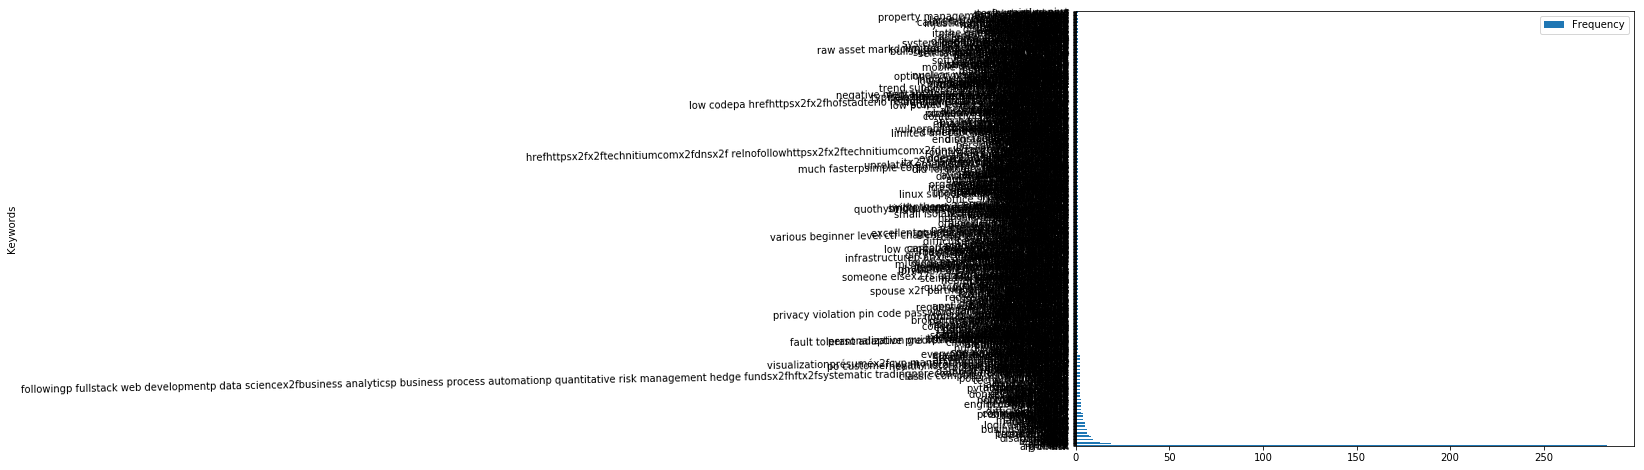

In [26]:
#converting RDD to spark dataframe
df_fDist = freq_neg_link_titles.toDF()

df_fDist.createOrReplaceTempView("myTable") 

#renaming columns 
df2 = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable limit 1000") 

#converting spark dataframes to pandas dataframes
pandDPos = df2.toPandas()
pandDPos.plot.barh(x='Keywords', y='Frequency', rot=1, figsize=(10,8))

In [27]:
#Write the top 100 words extracted from keyphrases to file. Both negative and positive
script_dir = os.getcwd()  #<-- absolute dir the script is in
rel_path = "..\data\Top1000KeyPositivePhrasesInComments.csv"
abs_file_path = os.path.join(script_dir, rel_path)

pandDPos.to_csv(abs_file_path)

script_dir = os.getcwd()  #<-- absolute dir the script is in
rel_path = "..\data\Top1000NegativeKeyPhrasesInComments.csv"
abs_file_path = os.path.join(script_dir, rel_path)

pandDNeg.to_csv(abs_file_path)